<a href="https://colab.research.google.com/github/AndresMtnezGlez/heptaomicron/blob/main/Andr%C3%A9s_Mart%C3%ADnez_unsupervised_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master//bgsedsc_0.jpg">

# Project: Unsupervised learning

## Programming project: patient clustering

In this project, you have to cluster patients that enter an ICU (Intensive Care Unit) by the features that one know in the very first day. At the end, we will check if these groups of patients have similar outcome results, in terms of probability of death.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Use the same dataset that you use for the 'probability of death' prediction Kaggle competition.


Main tasks are:
+ Using *train_prob_death.csv* file to cluster patient stays .
+ Check if resulting clusters are related to mortality of patients.
+ Try to explain which are the main drivers of your clusters

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
3. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
4. Build clusters.
5. Explore relationship between features, clusters and mortality.

## Main criteria for grading
From more to less important:
+ Code runs
+ Data preparation
+ Reasonable selection of cluster groups
+ Neat and understandable code, with some titles and comments
+ Good exploration of relation between clusters and patient outcomes
+ Improved methods from what we discussed in class (properly explained/justified)

#0. Import libraries and dataset
First we have to import the libraries we are going to use as well as to load the data. Since I'm having difficulties with the sinchronization of my Chrome Navigator, with both @gmail accounts (BGSE and personal) working with Collab to visualize notebooks, I have uploaded the dataset to my Github account so the notebook can be run from any machine connected to the Internet. 

We face a dataset with 13.840 entires and 39 columns. 

In [129]:
# Basic
import pandas as pd
import numpy as np
import datetime

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Missing values
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [130]:
# Main dataset
data=pd.read_csv('https://github.com/AndresMtnezGlez/heptaomicron/raw/main/train_prob_death.csv') # this is a relative path from current folder to the folder where you have the dataset
print(data.shape)
data_pure = data
data.head()


(13840, 39)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,ADMITTIME,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,1938-11-23,2008-06-15,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU
1,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,137.0,113.000000,F,1929-04-30,2008-09-12,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU
2,0,86233,184606,237514,62.0,100.0,82.862069,62.0,154.0,114.642857,34.0,113.0,56.964286,48.0,122.0,72.750000,11.0,26.0,18.878788,36.111111,37.722222,36.907407,87.0,100.0,96.931034,116.0,183.0,142.166667,F,1935-05-15,2009-05-21,ELECTIVE,Medicare,PROTESTANT QUAKER,MARRIED,WHITE,LEFT LUNG CANCER/SDA,1625,SICU
3,0,53787,174772,244413,84.0,109.0,94.652174,81.0,163.0,121.727273,29.0,77.0,47.909091,49.0,87.0,65.727273,15.0,25.0,19.869565,35.611111,36.944444,36.203704,89.0,100.0,92.913043,233.0,484.0,361.000000,F,1937-01-14,2008-02-06,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
4,0,99384,168087,298919,74.0,98.0,81.142857,84.0,140.0,113.875000,35.0,72.0,54.343750,31.0,81.0,66.806452,17.0,28.0,23.264706,35.888889,37.111111,36.652778,88.0,99.0,94.600000,85.0,161.0,112.000000,M,1924-08-05,2010-02-24,EMERGENCY,Medicare,BUDDHIST,WIDOWED,WHITE,PULMONARY EMBOLISM,41511,TSICU


Now, we create some user-defined functions. The rule of thumb is not to write code twice. If something repeats in the code, it easier to code if we wrapped it as a user defined function. 

In [131]:
   def plot_miss(data):
   # Function very similar to the one uploaded as solution to day 2 assigments.     
    plt.rcParams["figure.figsize"] = (14,3)
    ratio = 100*(data.isnull().sum()/(data.shape[0]))
    # Plot the ratios
    plt.bar(x=np.arange(len(ratio)),height=ratio,tick_label = ratio.index, color="skyblue")
    plt.title("Missing observations (as % of total)")
    plt.xticks(rotation=60)
    plt.show()

In [132]:
def categorical_other_converter(df,var,threshold):
    # Function very similar to the one uploaded as solution to day 2 assigments.     
    # Initialize lists to store the names of the small groups
    small_categories = []
    
    # Get the value counts for each group
    vals = df[var].value_counts()
    
    # Initialize counter
    counter = 0

    # Loop over groups
    for i in vals:
        # If a certain group has less than threshold observations, add it to the list
        if i<threshold:
            small_categories.append(vals.index[counter])
        
        # Increment counter
        counter += 1
        
    # Convert small groups into the other category
    df[var] = ['Other' if i in small_categories else i for i in df[var]]
    
    return df

#1. Explore the data
First, we want to plot the histogram of the numerical variables just in case we can easily see two or more cluster groups across the dimensions of data. However, it does not seem to be the case. 

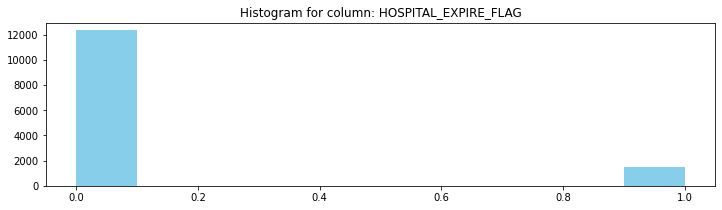

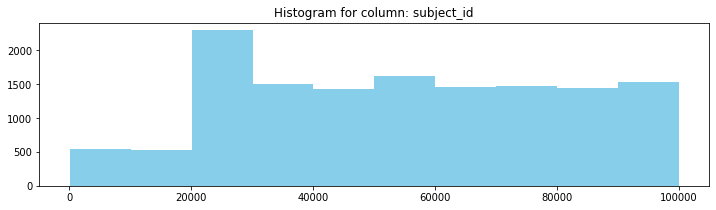

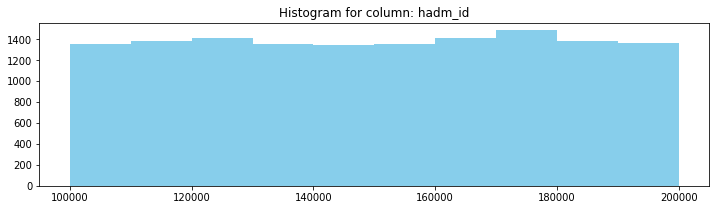

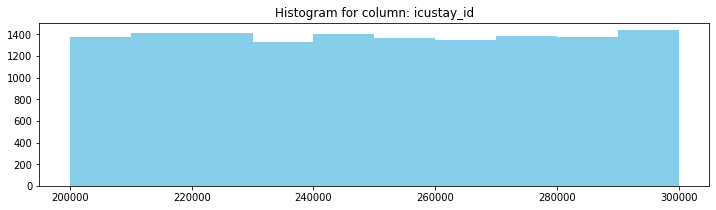

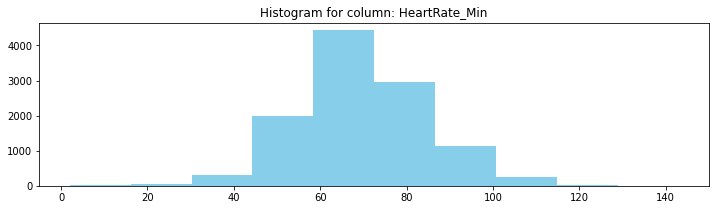

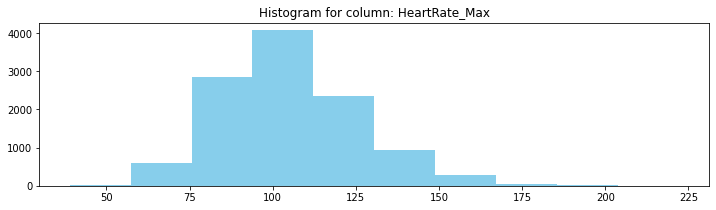

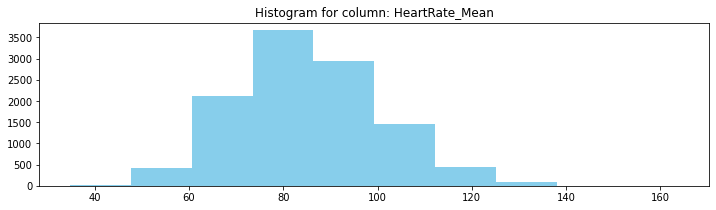

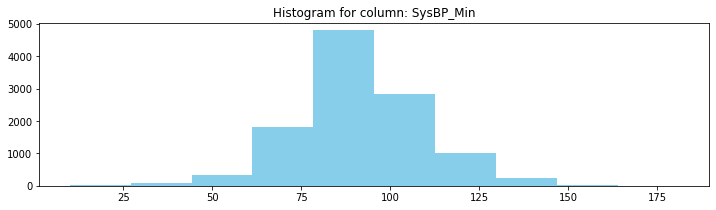

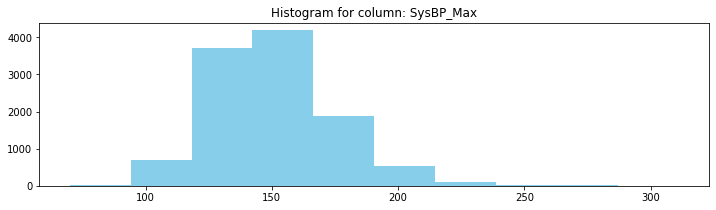

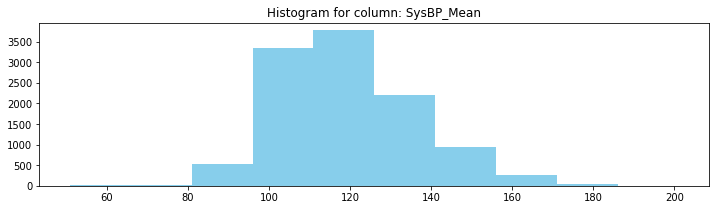

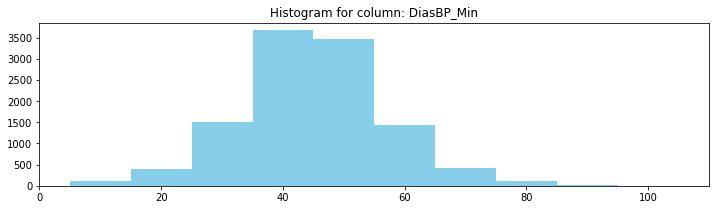

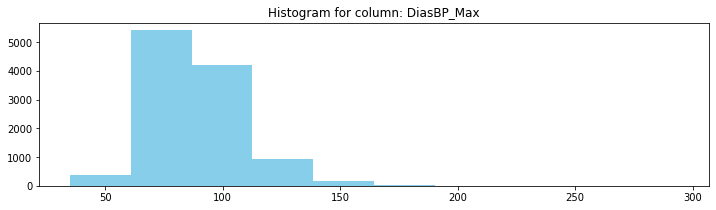

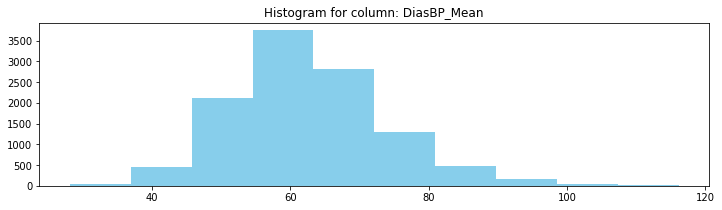

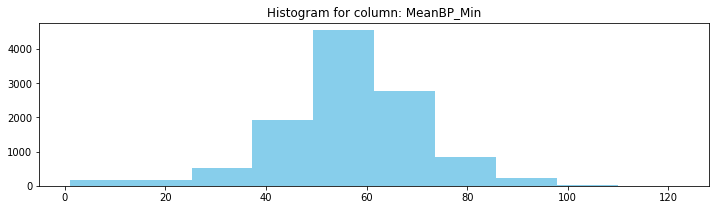

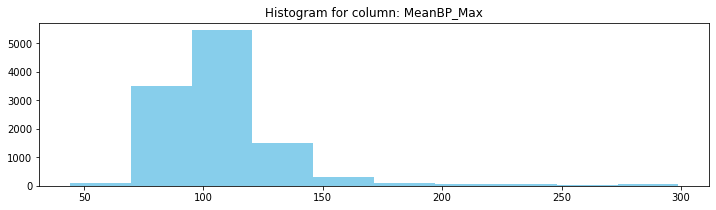

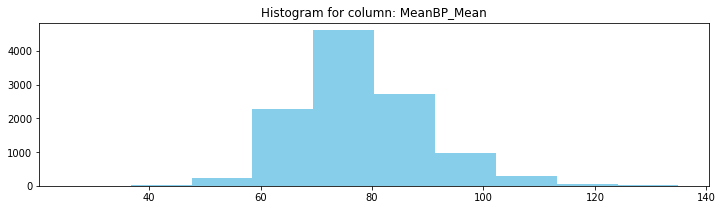

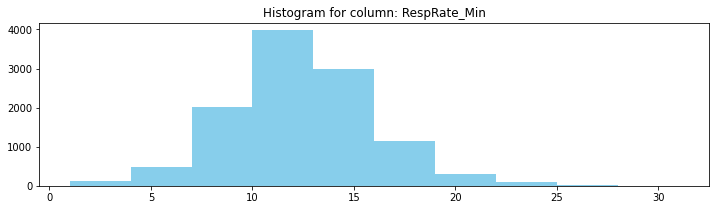

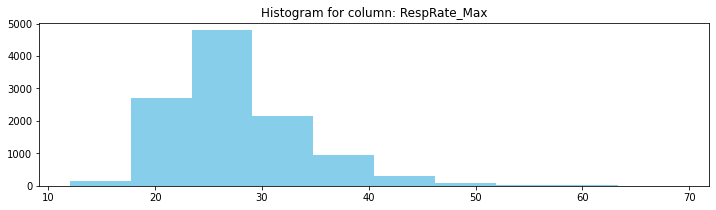

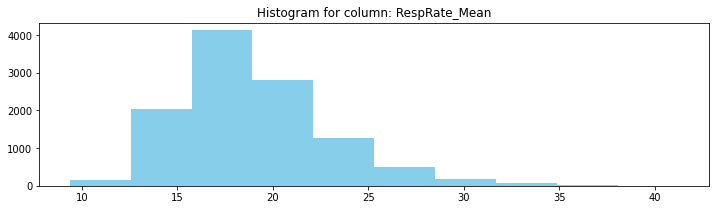

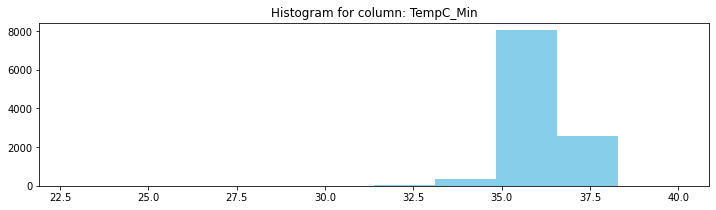

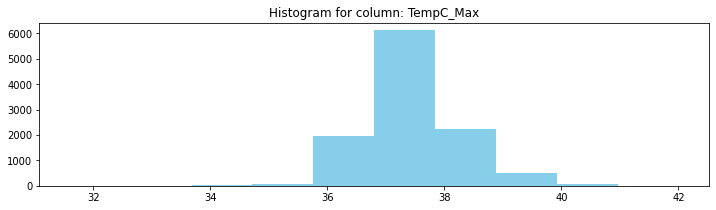

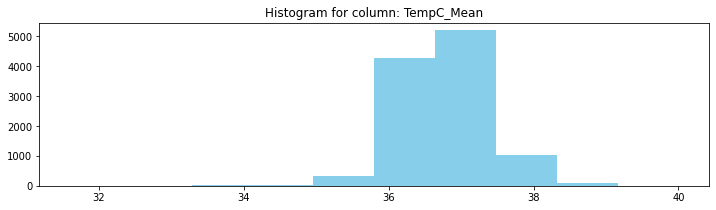

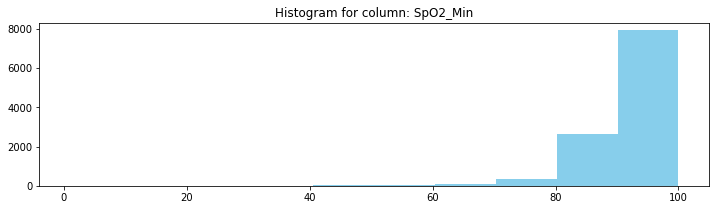

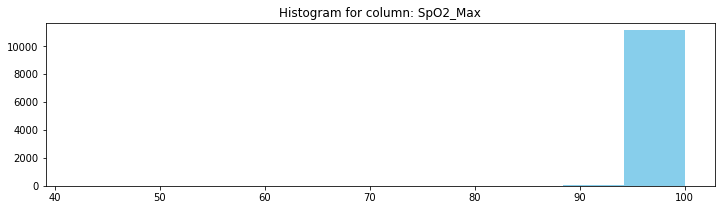

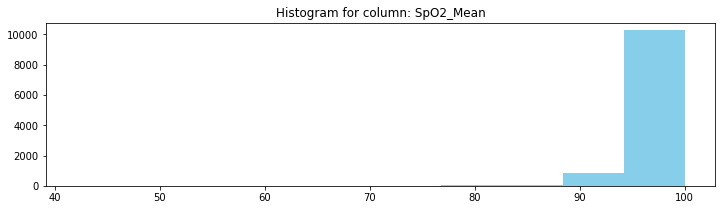

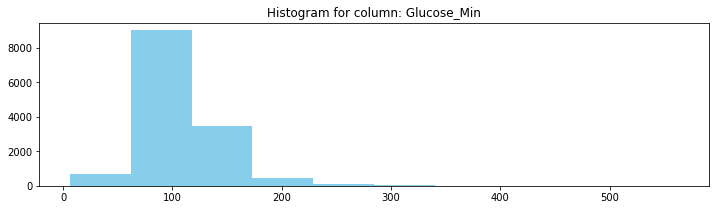

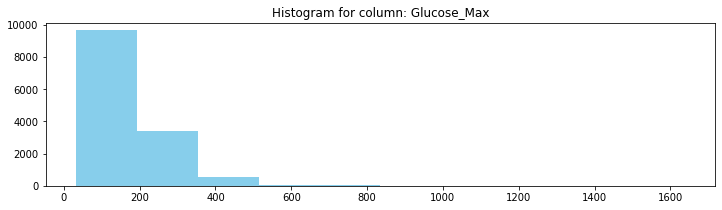

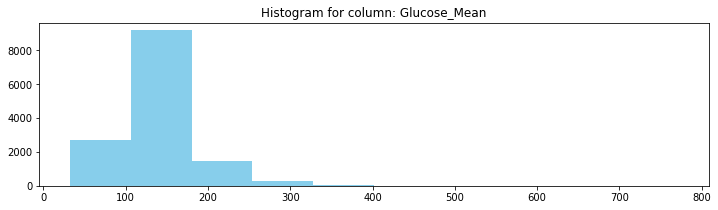

In [133]:
    # Set plot sizes
    plt.rcParams["figure.figsize"] = (12,3)
    
    for i in data.columns: # numerical variables
        if data[i].dtypes == 'int64' or data[i].dtypes == 'float64' or data[i].dtypes=='<M8[ns]':
            plt.hist(data[i], color="skyblue")
            plt.title("Histogram for column: {}".format(i))
            plt.show()
        else:
            pass

#2. Manage missing data
Once we have seen how our data looks like we have to deal with missing observations. Following the good pratices learned in the correction of projects for day 1 and day 2, first we got a graps of the dimension of the problem by plotting the share of missing observations by categorie. 

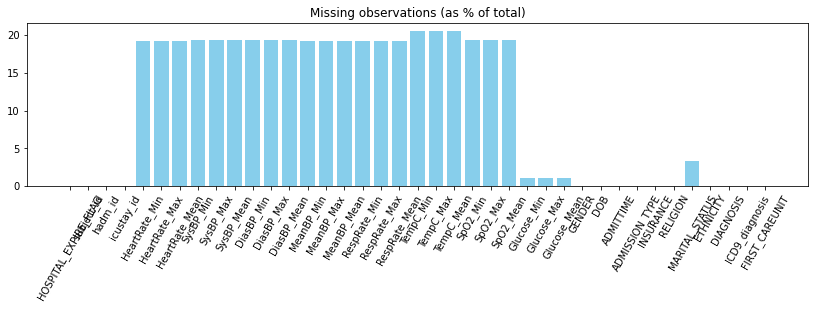

In [134]:
    plt.rcParams["figure.figsize"] = (14,3)
    ratio = 100*(data.isnull().sum()/(data.shape[0]))
    # Plot the ratios
    plt.bar(x=np.arange(len(ratio)),height=ratio,tick_label = ratio.index, color="skyblue")
    plt.title("Missing observations (as % of total)")
    plt.xticks(rotation=60)
    plt.show()

We see two issues.First, there seems to be a pretty homogenous missing entries across categories. Meaning, that if there is a missing entry in a category is likely there is also missing entries in all the other categories. The second issue is the "non numerical" variables. Clealy, there are missing observations in cateogrical variables that do not appear in the plot. 

In previous assigments we have substitute missing by columns means. Following correction's suggestion we will try to impute values with more sofisticated methods. To do so first we split among numerical and categorical variables in the lists num_vars and cat_vars. 

For the **numerical variables** we will impute the missing observations iterating the Kneighbors model with one neighborhood (up to twenty times) and setting it as starting point the median value. 

For the **categorical variables** we will just fill the blank space with the modal (most repeated) category. 

Finally, we make use of the user-defined function plot_miss() to make sure it has worked and there are no more missing entries. 

In [135]:
    dtype_list = data.dtypes
    num_vars = []
    
    for i in range(0,len(dtype_list)):
        if (dtype_list.index[i] not in ['HOSPITAL_EXPIRE_FLAG','subject_id','hadm_id','icustay_id','LOS']) & ((dtype_list[i]=='float64') | (dtype_list[i]=='int64')):
            num_vars.append(dtype_list.index[i])

    cat_vars = []
    for i in range(0,len(dtype_list)):
        if (dtype_list[i]=='object'):
            cat_vars.append(dtype_list.index[i])

Iterating through categorical variable GENDER
Iterating through categorical variable DOB
Iterating through categorical variable ADMITTIME
Iterating through categorical variable ADMISSION_TYPE
Iterating through categorical variable INSURANCE
Iterating through categorical variable RELIGION
Iterating through categorical variable MARITAL_STATUS
Iterating through categorical variable ETHNICITY
Iterating through categorical variable DIAGNOSIS
Iterating through categorical variable ICD9_diagnosis
Iterating through categorical variable FIRST_CAREUNIT


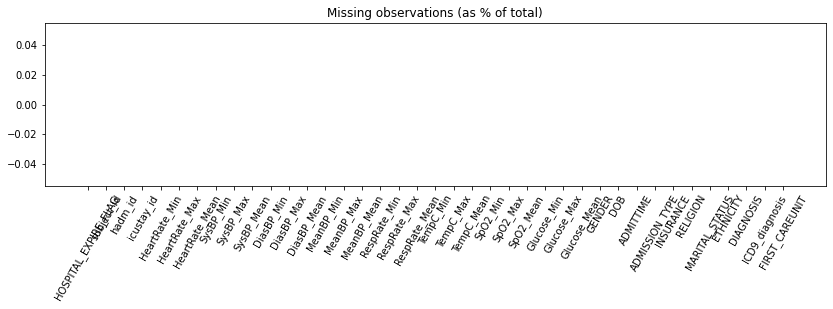

In [136]:
    # Iterative Kneighbor for numerical. 
    my_estimator = KNeighborsRegressor(n_neighbors=1)

    my_imputer=IterativeImputer(initial_strategy='median',random_state=0,
                                            estimator=my_estimator, max_iter=20,add_indicator=False)
    my_imputer.fit(data[num_vars])
    data[num_vars]=my_imputer.transform(data[num_vars])

    # Imputation with modal category
    for i in cat_vars:
        current_fill_value = data[i].value_counts().index[0]
        if current_fill_value==None:
            current_fill_value = data[i].value_counts().index[1]
        data[i] = data[i].fillna(current_fill_value)
        print("Iterating through categorical variable " + i)

plot_miss(data)

# 3. Manage categorial features
Once we have dealt with missing we have to deal with cateogrical features and with computational issues (meaning data types that can no be loaded as input in the models such as "objects" and some times "floats64") because they are either to "strange" or too heavy to compute. First, we will see what kind of data entries our dataframe has. 

However, to help the future model we will create an additonal category "Age" by substracting the DOB to ADMISIONTIME so we can know the age of the patient when enters in the ICU. 

In [137]:
data.dtypes

HOSPITAL_EXPIRE_FLAG      int64
subject_id                int64
hadm_id                   int64
icustay_id                int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
DOB                      object
ADMITTIME                object
ADMISSIO

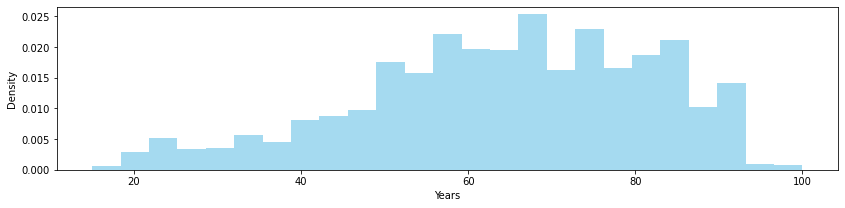

In [138]:
# Convert strings to date format
data['YEAR_DOB'] = pd.DatetimeIndex(data['DOB']).year
data['YEAR_ADMITTIME'] = pd.DatetimeIndex(data['ADMITTIME']).year
data['YEAR_AGE'] = data['YEAR_ADMITTIME'] - data['YEAR_DOB']
plt.hist(data.YEAR_AGE,25, density=2, facecolor='skyblue', alpha=0.75)
plt.xlabel('Years')
plt.ylabel('Density')
plt.title('')
plt.show()
data.drop(['YEAR_ADMITTIME', 'YEAR_DOB'], axis=1, inplace=True)


Now that we have created the variable age we are going going to dumify the categorical variables (they are either strings or alphanumeric codes). To do so and to avoid the dataframe to grow too many columns we will dummify with cumulative dummies. This is, if a category has 3 cateogories, let's say "A", "B" and "C", the rows with the category "A" will have a 0, the rows with "B" a 1, and with "C" a 2 and so on. Once we have done that we load the cleaner dataset in a new dataframe called "dta". 

In [139]:
dummy_cols = []
counter = 0
for i in data.dtypes:
    if i=='object':
        dummy_cols.append(data.dtypes.index[counter])
    counter += 1

In [140]:
dummy_cols_d = []
for i in dummy_cols:
    dummy = pd.get_dummies(data[i])
    dummy_name = "d_"
    dummy_name += i
    data[dummy_name] = dummy.cumsum(axis=1).ne(1).sum(axis=1)
    dummy_cols_d.append(dummy_name)
dta = data 

dta.drop(dummy_cols, axis=1, inplace=True)

print(dta.shape)
dta.head()


(13840, 40)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,YEAR_AGE,d_GENDER,d_DOB,d_ADMITTIME,d_ADMISSION_TYPE,d_INSURANCE,d_RELIGION,d_MARITAL_STATUS,d_ETHNICITY,d_DIAGNOSIS,d_ICD9_diagnosis,d_FIRST_CAREUNIT
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,70,0,3424,171,1,2,12,4,36,1846,890,2
1,0,28424,127337,225281,65.0,103.0,76.083333,90.0,144.0,115.500000,41.0,84.0,58.583333,53.0,100.0,72.166667,11.0,28.0,18.000000,36.222222,36.833333,36.574074,96.0,100.0,98.750000,97.0,137.0,113.000000,79,0,1873,260,1,2,8,6,36,69,824,4
2,0,86233,184606,237514,62.0,100.0,82.862069,62.0,154.0,114.642857,34.0,113.0,56.964286,48.0,122.0,72.750000,11.0,26.0,18.878788,36.111111,37.722222,36.907407,87.0,100.0,96.931034,116.0,183.0,142.166667,74,0,2880,511,0,2,12,2,36,2370,133,3
3,0,53787,174772,244413,84.0,109.0,94.652174,81.0,163.0,121.727273,29.0,77.0,47.909091,49.0,87.0,65.727273,15.0,25.0,19.869565,35.611111,36.944444,36.203704,89.0,100.0,92.913043,233.0,484.0,361.000000,71,0,3155,41,1,2,2,0,36,572,674,2
4,0,99384,168087,298919,74.0,98.0,81.142857,84.0,140.0,113.875000,35.0,72.0,54.343750,31.0,81.0,66.806452,17.0,28.0,23.264706,35.888889,37.111111,36.652778,88.0,99.0,94.600000,85.0,161.0,112.000000,86,1,1077,790,1,2,1,6,36,3307,478,4


## Scale numerical features
The correction of the day 2 project pointed out that "*You did not scale your features, which is not necessarily a problem for your models here, but could be an issue for regularized models for instance*" 
To avoid repiting this error we can scale the numerical features, to do so, first we have to distinguish between scalable numerical categories and cateogries where there are numbers but does not make to scale it becasue the number is not a cardinal but an ordinal measure (such as the ID Number). 

In [141]:
# Not features
non_feature_cols = ['HOSPITAL_EXPIRE_FLAG','subject_id','hadm_id','icustay_id']

# Create list of numerical + non-dummy features
non_numerical_list = set(dummy_cols_d + non_feature_cols)

numericals = list(set(dta.columns).difference(non_numerical_list))
  
# Initialize scaler
scaler = StandardScaler()
# Fit scaler
sc = scaler.fit(dta[numericals])
# Scale the relevant features in the dataset
dta[numericals] = sc.transform(dta[numericals])
dta.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,YEAR_AGE,d_GENDER,d_DOB,d_ADMITTIME,d_ADMISSION_TYPE,d_INSURANCE,d_RELIGION,d_MARITAL_STATUS,d_ETHNICITY,d_DIAGNOSIS,d_ICD9_diagnosis,d_FIRST_CAREUNIT
0,0,55440,195768,228357,1.406695,2.115583,2.564928,-1.089497,-1.061094,-0.797128,-0.237299,0.124532,-0.137243,0.173504,-0.459845,-0.282892,0.890717,0.437949,0.966018,-1.364920,-0.611186,-1.171269,-0.165000,-0.443530,-0.466577,0.091855,0.561603,0.490954,0.328577,0,3424,171,1,2,12,4,36,1846,890,2
1,0,28424,127337,225281,-0.329924,-0.076504,-0.621740,-0.099602,-0.279153,-0.216818,-0.329096,-0.212434,-0.391551,-0.281575,-0.225277,-0.514705,-0.256069,0.098376,-0.230006,0.223656,-0.757860,-0.299496,0.702684,0.348222,0.843150,-0.297885,-0.473341,-0.562291,0.846799,0,1873,260,1,2,8,6,36,69,824,4
2,0,86233,184606,237514,-0.547002,-0.233082,-0.141279,-1.831919,0.180812,-0.272625,-0.971675,1.416235,-0.550487,-0.660807,0.634805,-0.457812,-0.256069,-0.241198,0.011736,0.064799,0.415533,0.288950,-0.598842,0.348222,0.051901,0.231048,0.038567,0.080679,0.558898,0,2880,511,0,2,12,2,36,2370,133,3
3,0,53787,174772,244413,1.044900,0.236651,0.694375,-0.656418,0.594781,0.188627,-1.430661,-0.605561,-1.439404,-0.584961,-0.733508,-1.142747,0.890717,-0.410984,0.284285,-0.650061,-0.611186,-0.953326,-0.309614,0.348222,-1.695924,3.488158,3.388224,4.904787,0.386157,0,3155,41,1,2,2,0,36,572,674,2
4,0,99384,168087,298919,0.321308,-0.337467,-0.263133,-0.470813,-0.463139,-0.322618,-0.879878,-0.886366,-0.807736,-1.950197,-0.968075,-1.037493,1.464110,0.098376,1.218239,-0.252917,-0.391175,-0.160557,-0.454228,-0.443530,-0.962098,-0.631947,-0.206259,-0.584336,1.249860,1,1077,790,1,2,1,6,36,3307,478,4


#4. Build clusters
We are finally in a psotion to start modelling the dataset to divide it into clusters. The first step will be to rescale all the columns but the non feautre columns and have it as a raw numpy matrix instead of as a dataframe. 

In [142]:
X = dta.drop(columns=non_feature_cols,axis=1)
scaler = StandardScaler()
# Fit scaler
sc = scaler.fit(X)
# Scale the relevant features in the dataset
X = sc.transform(X)
X.shape

(13840, 36)

The second step is to carry the dimenasionality reduction, in this case we are going to first try to reduce from 36 categories to 10 pincipal components.  

In [143]:
pca_components = 10
pca = sklearn.decomposition.PCA(n_components=pca_components)

# Carry out PCA transformation
pca.fit(X)

# Project data onto the PCA dimension
X_transformed = pca.transform(X)

Now, we have projected our data from the 36 original cateogries to only 10 principal components. However, we must find out what is the optimal number of clusters. To do so we use the function KMeans. The Kmeans function finds the centroid (a data pont) at the center of each cluster. 

**How many clusters?** As we do not have prior knowloadge we are going to test many different numbers of clusters from 2 up to 12. 


**How to decide what is the optimal number of clusters?** One measure the function kmeans will yield is the inertia which is the sum of squared distances of samples to their closest cluster center  

Ideally we are looking for an elbow shape so we 


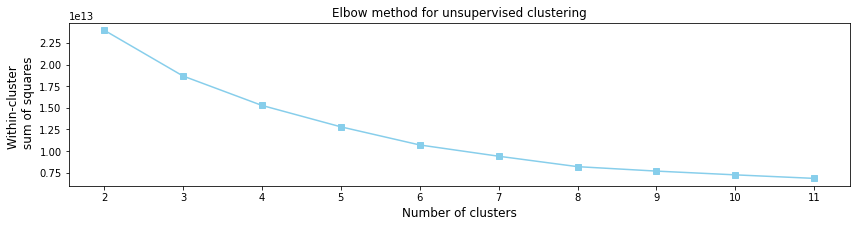

In [144]:
# Try to find best number of clusters
potential_cluster_nums = np.arange(2,12,1)

wcss = []
for n in potential_cluster_nums:
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(X=data)
            wcss.append(kmeans.inertia_)

clustering_inertia_vals = wcss            

plt.plot(potential_cluster_nums,clustering_inertia_vals,marker="s", color='skyblue')
plt.xlabel("Number of clusters",fontsize=12)
plt.xticks(np.arange(min(potential_cluster_nums), max(potential_cluster_nums)+1, 1.0))
plt.ylabel("Within-cluster \n sum of squares",fontsize=12)
plt.title("Elbow method for unsupervised clustering",fontsize=12)
plt.show()

Unfortunatley, conductiong and eyeballing test does not show clearly where the tradeoff starts and therefore where is optimal to cut the number of clusters. mean_exitus. To help avoid this issue we will see the reudction, or the drop in de sum of squares whith in clusters that happens at each number of clusters. Below, it seems more clear that 6 is the optimal number of clusters, because later of the drop is too heavy. Other option could be 8, but the more clusters the more difficult to create a story or contextualize the data

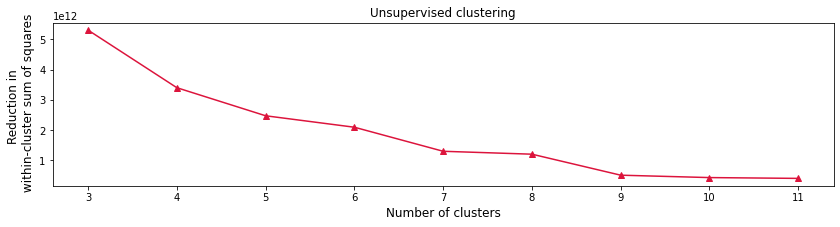

In [145]:
clustering_inertia_vals_diffs = [clustering_inertia_vals[i]-clustering_inertia_vals[i+1] for i in range(0,len(clustering_inertia_vals)-1)]
plt.plot(potential_cluster_nums[1:],clustering_inertia_vals_diffs,marker="^", color='crimson')
plt.xlabel("Number of clusters",fontsize=12)
plt.ylabel("Reduction in \n within-cluster sum of squares",fontsize=12)
plt.title("Unsupervised clustering",fontsize=12)
plt.show()

##K-means clustering

In [146]:
cluster_labels =  KMeans(n_clusters=6,algorithm="full",max_iter=300).fit(X_transformed).labels_

#5. Explore relationship between features, clusters and mortality.

Once we have decided the optimal number of clusters we have to check if they are any usuful for clustering. *What does proper clustering mean?* It means that we have divided the dataset in several groups (6) and these groups differ in key parameters. In particular we are interested if the grouping helps to isolate those individuals with higher chance of mortality (exitus) from those with low mortality likelihood. 

The plot below shows the average mortality per cluster from (blue bins) and the average mortality of the dataset. It is clear that all clusters (but probabilily the number 3) are far away from the global average. The more far away the better because that means that your clusters are very much different from each other . 

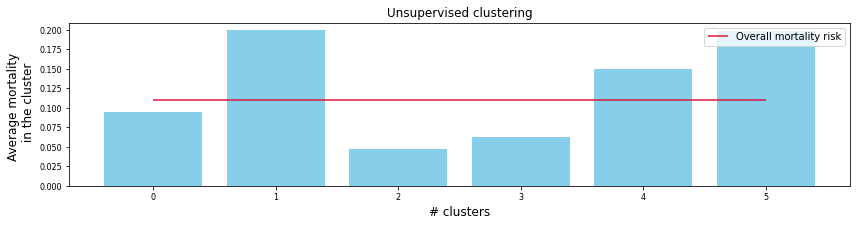

In [147]:
exitus_target = 'HOSPITAL_EXPIRE_FLAG'
y_exitus = dta['HOSPITAL_EXPIRE_FLAG']

clust_mortality = []
for i in range(0,len(cluster_labels)):
    clust_mortality.append((cluster_labels[i],y_exitus.iloc[i]))

clust_mortality_table = pd.DataFrame(clust_mortality, columns=['cluster', 'mortality'])
mean_exitus = clust_mortality_table.groupby('cluster').mean()

general_mort_risk_mean = np.mean(dta[exitus_target])

plt.bar(np.arange(mean_exitus.shape[0]),
        mean_exitus.mortality,  color='skyblue')
plt.hlines(general_mort_risk_mean,0,mean_exitus.shape[0]-1,
           colors="crimson",label="Overall mortality risk")
plt.xlabel("# clusters",fontsize=12)
plt.ylabel("Average mortality \n in the cluster",fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title("Unsupervised clustering",fontsize=12)
plt.legend(loc='upper right')
plt.show()

Another way to visualize our six groups is to 2-d plot the dataset with a scatter plot, where the colour will be the category or cluster where each data point belongs  to. The eyeballing test indicates that the clustering by kmeans performed over the PCA reduced categories has worked reasonabily well in the first eight categories. However, in the last two graphs seems that the datapoints are too close one to another and there is not important separation. One way to fix this issue could be to select another dimensionality reduction or to select other number of dimensions that is not 10. 

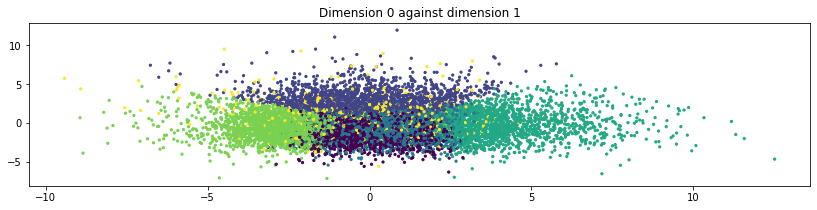

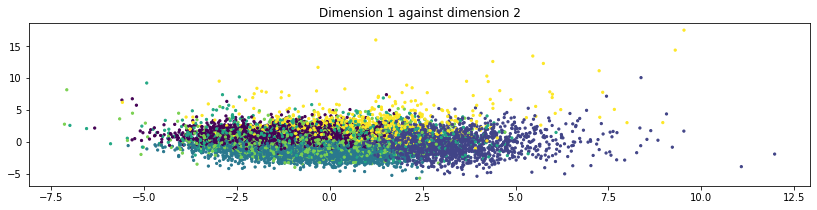

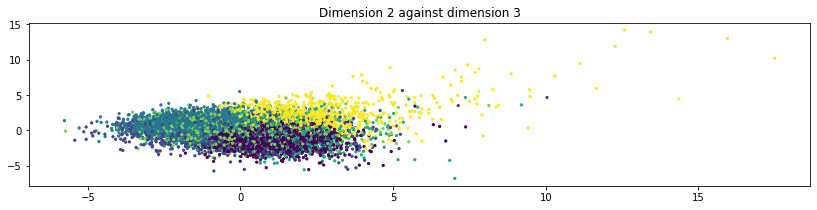

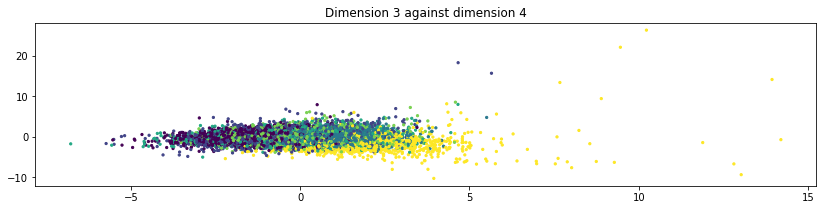

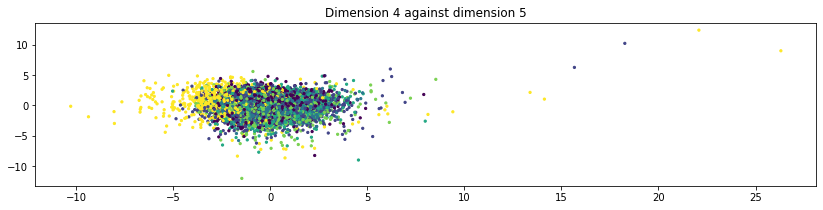

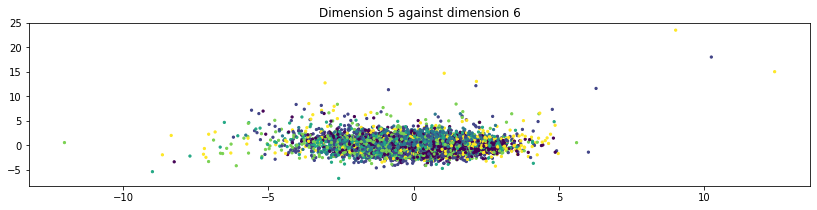

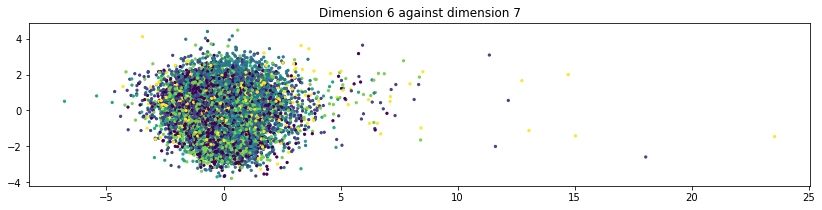

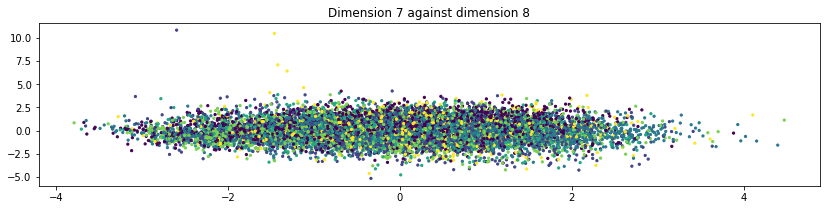

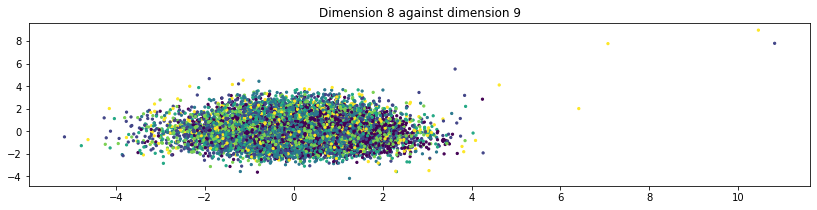

In [148]:
for i in range(0,X_transformed.shape[1]-1):
    h = i+1
    plt.scatter(X_transformed[:, i], X_transformed[:, h], c=cluster_labels, s=5, cmap='viridis')
    dummy_name = "Dimension "
    dummy_name += str(i)
    dummy_name += " against dimension "
    dummy_name += str(h)
    plt.title(dummy_name ,fontsize=12)
    plt.show()

As we can see tehre are 3/4 categories or clusters which seem to be very promient in all plots while a couple of them are a either overlapped or low populated. We can see how many are in each observation with a simple bar lot. 

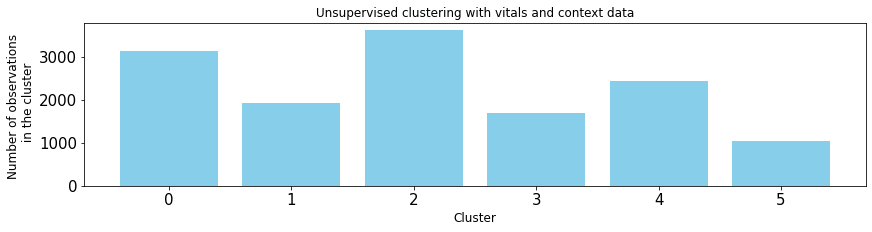

In [149]:
cluster_sizes_df = clust_mortality_table.groupby('cluster').count()
cluster_sizes_df
plt.bar(np.arange(cluster_sizes_df.shape[0]),
        cluster_sizes_df.mortality, color ='skyblue')
plt.xlabel("Cluster",fontsize=12)
plt.ylabel("Number of observations \n in the cluster",fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title("Unsupervised clustering with vitals and context data",fontsize=12)
plt.show()

This assymetry in the population of the clusters might be a consequence of the asymetrical relationship that there is in the dataset when we plot the correlation matrix and see how just a few numerical variables (excluding very extreme values) have and important (either positive correlation). 


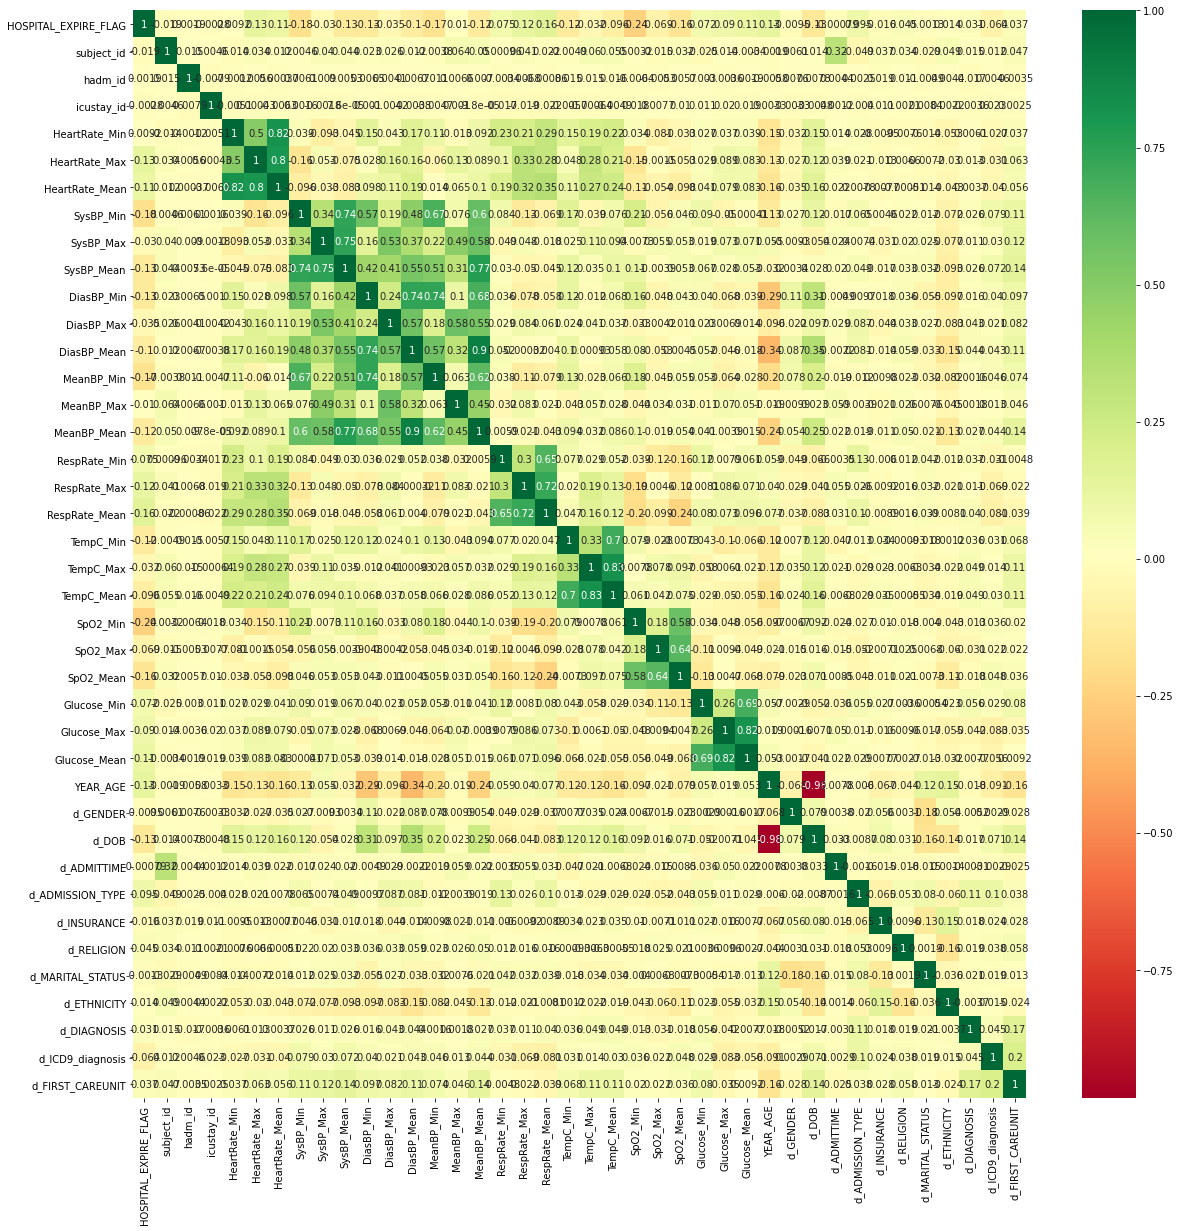

In [150]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# 6.Conclusion 
In this assigment we have tried to cluster patients that enter an ICU (Intensive Care Unit) by the features that one know in the very first day. We have checked that these groups of patients have different outcome results in terms of probability of death.

Nevertheless, we could not find a convinincg story that drives this clustering. This may be a consequence of the trade-off between predictive accuracy and explainability. The dimension reduction (conducted with PCA) has helped very much to get ride off the noise and focus on the more explicative (in terms of variance) latent variables. But this has come at the cost of not being able to clearly explain the features with the highest importance. A further iteration should be to being able to explain why we classify a patient in a group with high probabilty or low of death. 